# Explainable Outlier Detection in Titanic dataset

This short notebook illustrates basic usage of the [OutlierTree](https://github.com/david-cortes/outliertree) library for explainable outlier detection using the Titanic dataset. For more details, you can check the package's documentation [here](http://outliertree.readthedocs.io/en/latest/).

The dataset is very popular and can be downloaded from different sources, such as Kaggle or many university webpages. This notebook took it from the following link: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv
** *

### Loading the raw data

In [1]:
import numpy as np, pandas as pd
from outliertree import OutlierTree

## Read the raw data, downloaded from here:
## http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv
titanic = pd.read_csv("titanic3.csv")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Pre-processing the data

In [2]:
## Capitalize column names and some values for easier reading
titanic.columns = titanic.columns.str.capitalize()
titanic = titanic.rename(columns = {"Sibsp" : "SibSp"})
titanic["Sex"] = titanic["Sex"].str.capitalize()

## Convert 'survived' to yes/no for easier reading
titanic["Survived"] = titanic["Survived"].astype("category").replace({1:"Yes", 0:"No"})

## Some columns are not useful, such as name (an ID), ticket number (another ID),
## or destination (too many values, many non-repeated)
cols_drop = ["Name", "Ticket", "Home.dest"]
titanic = titanic.drop(cols_drop, axis=1)

## Ordinal columns need to be passed as ordered categoricals
cols_ord = ["Pclass", "Parch", "SibSp"]
for col in cols_ord:
    titanic[col] = pd.Categorical(titanic[col], ordered=True)

titanic.head()

,Pclass,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Boat,Body
0,1,Yes,Female,29.00,0,0,211.3375,B5,S,2,NaN
1,1,Yes,Male,0.92,1,2,151.5500,C22 C26,S,11,NaN
2,1,No,Female,2.00,1,2,151.5500,C22 C26,S,NaN,NaN
3,1,No,Male,30.00,1,2,151.5500,C22 C26,S,NaN,135.0
4,1,No,Female,25.00,1,2,151.5500,C22 C26,S,NaN,NaN


### Fitting a model

In [3]:
## Fit model with default hyperparameters
otree = OutlierTree()
otree.fit(titanic)

Reporting top 9 outliers [out of 9 found]


row [170] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.571% >= 25.742 - [mean: 55.220] - [sd: 27.557] - [norm. obs: 69]
	given:
		[Pclass] = [1]
		[Boat] in [1, 12, 13 15, 13 15 B, 15, 15 16, 16, 5, 5 7, 5 9, 7, 8 10, 9, B, C, C D] (value: C)


row [18] - suspicious column: [Age] - suspicious value: [32.000]
	distribution: 96.000% >= 43.000 - [mean: 48.354] - [sd: 3.164] - [norm. obs: 24]
	given:
		[Cabin] in [A16, A20, B10, B52 B54 B56, B82 B84, C110, C116, C124, C126, C86, C92, D15, D17, D33, D46, E12, E31, E58, E63] (value: D15)


row [896] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 99.216% >= 3.171 - [mean: 9.680] - [sd: 6.984] - [norm. obs: 506]
	given:
		[Pclass] = [3]
		[SibSp] = [0]


row [898] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 99.216% >= 3.171 - [mean: 9.680] - [sd: 6.984] - [norm. obs: 506]
	given:
		[Pclass] = [3]
		[SibSp] = [0]


row [96

OutlierTree model
	Numeric variables: 3
	Categorical variables: 5
	Ordinal variables: 3

Consists of 220 clusters, spread across 16 tree branches

### Examining the results more closely

In [4]:
## Double-check the data (last 2 outliers)
titanic.loc[[1146, 1163]]

,Pclass,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Boat,Body
1146,3,No,Female,39.0,0,5,29.125,NaN,Q,NaN,327.0
1163,3,No,Male,NaN,0,0,24.150,NaN,Q,NaN,NaN


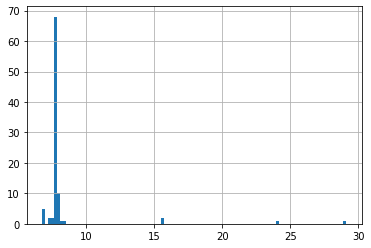

In [5]:
## Distribution of the group from which those two outliers were flagged
%matplotlib inline
titanic.loc[
    (titanic.Pclass == 3)     &
    (titanic.SibSp == 0)      &
    (titanic.Embarked == "Q")
] .Fare.hist(bins=100)

In [6]:
## Get the outliers in a manipulable format
otree.predict(titanic).loc[[1146, 1163]]

,suspicous_value,group_statistics,conditions,tree_depth,uses_NA_branch,outlier_score
1146,"{'column': 'Fare', 'value': 29.125}","{'upper_thr': 15.5, 'pct_below': 0.97849462365...","[{'column': 'Embarked', 'comparison': '=', 'va...",4.0,0.0,0.003805
1163,"{'column': 'Fare', 'value': 24.15}","{'upper_thr': 15.5, 'pct_below': 0.97849462365...","[{'column': 'Embarked', 'comparison': '=', 'va...",4.0,0.0,0.005227


In [7]:
## To programatically get all the outliers that were flagged
pred = otree.predict(titanic)
pred.loc[~pred.outlier_score.isnull()]

,suspicous_value,group_statistics,conditions,tree_depth,uses_NA_branch,outlier_score
18,"{'column': 'Age', 'value': 32.0}","{'lower_thr': 43.0, 'pct_above': 0.96, 'mean':...","[{'column': 'Cabin', 'comparison': 'in', 'valu...",3.0,0.0,0.007545
170,"{'column': 'Fare', 'value': 0.0}","{'lower_thr': 25.7417, 'pct_above': 0.98571428...","[{'column': 'Boat', 'comparison': 'in', 'value...",2.0,0.0,0.015339
896,"{'column': 'Fare', 'value': 0.0}","{'lower_thr': 3.1708, 'pct_above': 0.992156862...","[{'column': 'Pclass', 'comparison': '=', 'valu...",3.0,0.0,0.011148
898,"{'column': 'Fare', 'value': 0.0}","{'lower_thr': 3.1708, 'pct_above': 0.992156862...","[{'column': 'Pclass', 'comparison': '=', 'valu...",3.0,0.0,0.011148
963,"{'column': 'Fare', 'value': 0.0}","{'lower_thr': 3.1708, 'pct_above': 0.992156862...","[{'column': 'Pclass', 'comparison': '=', 'valu...",3.0,0.0,0.011148
1044,"{'column': 'Fare', 'value': 15.5}","{'upper_thr': 8.5167, 'pct_below': 0.967741935...","[{'column': 'Boat', 'comparison': 'in', 'value...",4.0,0.0,0.002018
1146,"{'column': 'Fare', 'value': 29.125}","{'upper_thr': 15.5, 'pct_below': 0.97849462365...","[{'column': 'Embarked', 'comparison': '=', 'va...",4.0,0.0,0.003805
1163,"{'column': 'Fare', 'value': 24.15}","{'upper_thr': 15.5, 'pct_below': 0.97849462365...","[{'column': 'Embarked', 'comparison': '=', 'va...",4.0,0.0,0.005227
1254,"{'column': 'Fare', 'value': 0.0}","{'lower_thr': 3.1708, 'pct_above': 0.992156862...","[{'column': 'Pclass', 'comparison': '=', 'valu...",3.0,0.0,0.011148


In [8]:
## To print selected rows only
otree.print_outliers(pred.loc[[1146]])

Reporting top 1 outliers [out of 1 found]


row [1146] - suspicious column: [Fare] - suspicious value: [29.125]
	distribution: 97.849% <= 15.500 - [mean: 7.887] - [sd: 1.173] - [norm. obs: 91]
	given:
		[Pclass] = [3]
		[SibSp] = [0]
		[Embarked] = [Q]




### Trying different hyperparameters

In [9]:
## In order to flag more outliers, one can also experiment
## with lowering the threshold hyperparameters
OutlierTree(z_outlier=6.).fit(titanic, outliers_print=5)

Reporting top 5 outliers [out of 20 found]


row [363] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs: 682]
	given:
		[Pclass] in [2, 3] (value: 2)
		[SibSp] = [0]


row [384] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs: 682]
	given:
		[Pclass] in [2, 3] (value: 2)
		[SibSp] = [0]


row [410] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs: 682]
	given:
		[Pclass] in [2, 3] (value: 2)
		[SibSp] = [0]


row [473] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs: 682]
	given:
		[Pclass] in [2, 3] (value: 2)
		[SibSp] = [0]


row [528] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - 

OutlierTree model
	Numeric variables: 3
	Categorical variables: 5
	Ordinal variables: 3

Consists of 216 clusters, spread across 16 tree branches

In [10]:
## One can also lower the gain threshold, but this tends
## to result in more spurious outliers which come from
## not-so-good splits (not recommended)
OutlierTree(z_outlier=6, min_gain=1e-6).fit(titanic, outliers_print=5)

Reporting top 5 outliers [out of 27 found]


row [545] - suspicious column: [SibSp] - suspicious value: [3]
	distribution: 99.701% in [0, 1, 2, 5, 8]
	( [norm. obs: 999] - [prior_prob: 1.528%] - [next smallest: 2.595%] )
	given:
		[Parch] = [0]


row [656] - suspicious column: [SibSp] - suspicious value: [3]
	distribution: 99.701% in [0, 1, 2, 5, 8]
	( [norm. obs: 999] - [prior_prob: 1.528%] - [next smallest: 2.595%] )
	given:
		[Parch] = [0]


row [1274] - suspicious column: [SibSp] - suspicious value: [3]
	distribution: 99.701% in [0, 1, 2, 5, 8]
	( [norm. obs: 999] - [prior_prob: 1.528%] - [next smallest: 2.595%] )
	given:
		[Parch] = [0]


row [363] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs: 682]
	given:
		[Pclass] in [2, 3] (value: 2)
		[SibSp] = [0]


row [384] - suspicious column: [Fare] - suspicious value: [0.000]
	distribution: 98.555% >= 3.171 - [mean: 11.658] - [sd: 9.017] - [norm. obs:

OutlierTree model
	Numeric variables: 3
	Categorical variables: 5
	Ordinal variables: 3

Consists of 285 clusters, spread across 23 tree branches